In [ ]:
import random
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2


def create_license_plate(plate_width=256, plate_height=64, font_size=100, num_chars=6, fill_density=0.9):
    plate_number = "".join(str(random.randint(0, 9)) for _ in range(num_chars))

    base_plate = Image.new("RGB", (plate_width, plate_height), (255, 203, 9))
    drawer = ImageDraw.Draw(base_plate)
    try:
        font = ImageFont.truetype("bahnschrift.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    usable_width = plate_width * fill_density
    cell_width = int(usable_width / num_chars)
    margin_x = int((plate_width - cell_width * num_chars) / 2)
    margin_y = 10
    center_y = plate_height / 2

    for i, char in enumerate(plate_number):
        left, top, right, bottom = drawer.textbbox((0, 0), char, font=font)
        char_w, char_h = right - left, bottom - top

        cell_left = margin_x + i * cell_width
        center_x = cell_left + cell_width / 2

        x = center_x - char_w / 2 - left
        y = center_y - char_h / 2 - top
        drawer.text((x, y), char, fill=(0, 0, 0), font=font)

    digit_bboxes = [
        (margin_x + i * cell_width, margin_y, cell_width, plate_height - 2 * margin_y) for i in range(num_chars)
    ]

    padded_w = int(plate_width * 1.5)
    padded_h = int(plate_height * 2)
    padded_img = Image.new("RGB", (padded_w, padded_h), (0, 0, 0))

    pad_x = (padded_w - plate_width) // 2
    pad_y = (padded_h - plate_height) // 2
    padded_img.paste(base_plate, (pad_x, pad_y))

    plate_corners = [
        (pad_x, pad_y),
        (pad_x + plate_width - 1, pad_y),
        (pad_x + plate_width - 1, pad_y + plate_height - 1),
        (pad_x, pad_y + plate_height - 1),
    ]

    return padded_img, plate_corners, plate_number, digit_bboxes


# =====================================
# Warping and Noise
# =====================================


def warp_image(image, src_points, alpha, beta, f):
    # Convert RGB to BGR for OpenCV operations
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Ensure src_points is a numpy array
    src_points = np.array(src_points, dtype=np.float32)

    # Convert degrees to radians
    alpha_rad = np.deg2rad(alpha)  # Rotation angle around the y-axis
    beta_rad = np.deg2rad(beta)  # Rotation angle around the x-axis

    # Rotation matrices around the x-axis
    R_x = np.array(
        [
            [1, 0, 0],
            [0, np.cos(beta_rad), -np.sin(beta_rad)],
            [0, np.sin(beta_rad), np.cos(beta_rad)],
        ]
    )

    # Rotation matrices around the y-axis
    R_y = np.array(
        [
            [np.cos(alpha_rad), 0, np.sin(alpha_rad)],
            [0, 1, 0],
            [-np.sin(alpha_rad), 0, np.cos(alpha_rad)],
        ]
    )

    # Combined rotation
    R = np.dot(R_y, R_x)

    # Calculate the center of the source points
    center_x = np.mean(src_points[:, 0])
    center_y = np.mean(src_points[:, 1])
    center = np.array([center_x, center_y])

    # Calculate new positions after applying the rotation
    dst_points = []

    for point in src_points:
        # Convert to homogeneous coordinates (3D)
        x, y = point - center
        z = 0
        vec = np.dot(R, np.array([x, y, z]))

        # Project back to 2D
        x_proj = center[0] + f * (vec[0] / (f + vec[2]))
        y_proj = center[1] + f * (vec[1] / (f + vec[2]))

        dst_points.append([x_proj, y_proj])

    # Ensure src_points and dst_points are float32
    src_points = np.float32(src_points)
    dst_points = np.float32(dst_points)

    # Get the perspective transformation matrix and apply it
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_image = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_AREA)

    # Convert BGR back to RGB
    warped_image_rgb = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)

    return warped_image_rgb, dst_points


def dewarp_image(image, src_points, dst_points):
    # Convert RGB to BGR for OpenCV operations
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Ensure src_points and dst_points are numpy arrays
    src_points = np.array(src_points, dtype=np.float32)

    # Ensure src_points and dst_points are float32
    src_points = np.float32(src_points)
    dst_points = np.float32(dst_points)

    # Get the inverse perspective transformation matrix and apply it
    M_inv = cv2.getPerspectiveTransform(dst_points, src_points)
    dewarped_image = cv2.warpPerspective(image, M_inv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LANCZOS4)

    # Convert BGR back to RGB
    dewarped_image_rgb = cv2.cvtColor(dewarped_image, cv2.COLOR_BGR2RGB)

    return dewarped_image_rgb


def crop_to_original_size(image, original_width, original_height):
    height, width = image.shape[:2]

    # Calculate cropping coordinates to get the central region
    left = (width - original_width) // 2
    top = (height - original_height) // 2
    right = left + original_width
    bottom = top + original_height

    # Crop and return the image
    cropped_image = image[top:bottom, left:right]
    return cropped_image


def simulate_noise(image):

    # apply double edge detection
    kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
    double_edges = cv2.filter2D(image, -1, kernel)
    blurred_image = cv2.addWeighted(image, 0.7, double_edges, 0.3, 0)
    image_bgr = cv2.cvtColor(blurred_image.astype(np.uint8), cv2.COLOR_RGB2BGR)

    # Simplified ISP pipeline
    # Auto white balance (random scaling of R and B channels)
    b, g, r = cv2.split(image_bgr)
    # Apply random scaling to R and B channels
    r_scale = np.random.uniform(0.8, 1.2)  # Random factor between 0.8 and 1.2
    b_scale = np.random.uniform(0.8, 1.2)  # Independent random factor for blue
    r_adjusted = np.clip(r * r_scale, 0, 255).astype(np.uint8)
    b_adjusted = np.clip(b * b_scale, 0, 255).astype(np.uint8)
    # Merge channels back together
    image_bgr = cv2.merge([b_adjusted, g, r_adjusted])

    # Denoising (light Gaussian blur)
    image_bgr = cv2.GaussianBlur(image_bgr, (3, 3), sigmaX=1.0, sigmaY=1.0)

    # JPEG compression simulation quality 20 block size 8x8
    _, encoded = cv2.imencode(".jpg", image_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), 20])
    image_bgr = cv2.imdecode(encoded, cv2.IMREAD_COLOR)

    # Add Contrast
    alpha = np.random.uniform(1.4, 1.6)  # Contrast control (1.4-1.6)
    beta = np.random.uniform(-55, -45)  # Brightness control (-45, -55)
    image_bgr = cv2.convertScaleAbs(image_bgr, alpha=alpha, beta=beta)

    # Add 1% Gaussian noise
    std_dev = 0.01 * 255
    noise = np.random.normal(0, std_dev, image_bgr.shape)
    image_bgr = np.clip(image_bgr + noise, 0, 255).astype(np.uint8)

    # Convert back to RGB and return
    noisy_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    return noisy_rgb


def downscale_plate(image, bboxes, target_size):
    h, w = image.shape[:2]
    tw, th = target_size
    sx, sy = tw / w, th / h
    blurred_image = cv2.GaussianBlur(image, (3, 3), sigmaX=0.5, sigmaY=0.5)
    down_img = cv2.resize(blurred_image, (tw, th), interpolation=cv2.INTER_AREA)
    down_bboxes = [(int(x * sx), int(y * sy), int(w_ * sx), int(h_ * sy)) for (x, y, w_, h_) in bboxes]
    return down_img, down_bboxes

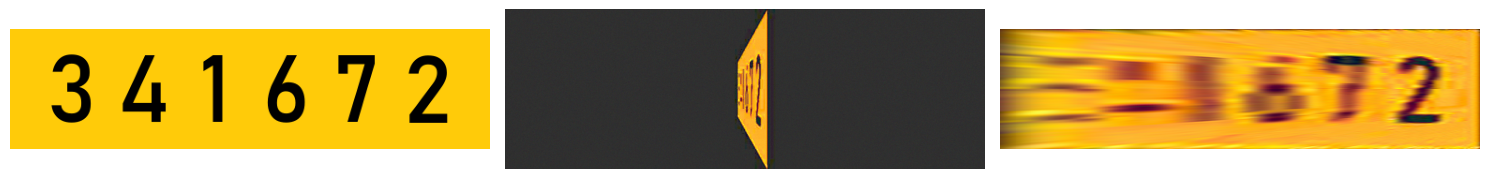

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Seed and parameters
random.seed(4)
np.random.seed(4)
width, height = 512, 128
alpha, beta, f = 86, 0, width

# Create and process plate
padded_img, src_pts, plate_num, digit_bboxes = create_license_plate(width, height, 100, 6, 0.9)
img_rgb = np.array(padded_img)
warped_rgb, dst_pts = warp_image(img_rgb, src_pts, alpha, beta, f)
noisy_rgb = simulate_noise(warped_rgb)
dewarped_rgb = dewarp_image(noisy_rgb, src_pts, dst_pts)

# Crop
clean_crop = crop_to_original_size(img_rgb, width, height)
dewarped_crop = crop_to_original_size(dewarped_rgb, width, height)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(clean_crop)
axs[0].axis("off")
axs[1].imshow(noisy_rgb)
axs[1].axis("off")
axs[2].imshow(dewarped_crop)
axs[2].axis("off")
plt.tight_layout()
plt.show()

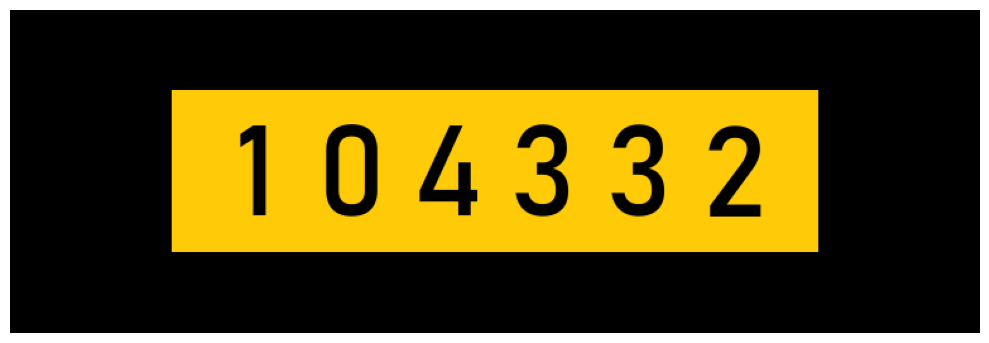

In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

seed = 42
random.seed(seed)
np.random.seed(seed)

# Plate and background settings
plate_width = 512
plate_height = 128
font_size = 100
num_chars = 6
fill_density = 0.9  # Fraction of plate width occupied by digits

plate_number = "".join(str(random.randint(0, 9)) for _ in range(num_chars))

base_plate = Image.new("RGB", (plate_width, plate_height), (255, 203, 9))
drawer = ImageDraw.Draw(base_plate)
try:
    font = ImageFont.truetype("bahnschrift.ttf", font_size)
except IOError:
    font = ImageFont.load_default()

usable_width = plate_width * fill_density
cell_width = int(usable_width / num_chars)
margin_x = int((plate_width - cell_width * num_chars) / 2)
margin_y = 10
center_y = plate_height / 2

for i, char in enumerate(plate_number):
    left, top, right, bottom = drawer.textbbox((0, 0), char, font=font)
    char_w, char_h = right - left, bottom - top

    cell_left = margin_x + i * cell_width
    center_x = cell_left + cell_width / 2

    x = center_x - char_w / 2 - left
    y = center_y - char_h / 2 - top
    drawer.text((x, y), char, fill=(0, 0, 0), font=font)

digit_bboxes = [
    (margin_x + i * cell_width, margin_y, cell_width, plate_height - 2 * margin_y) for i in range(num_chars)
]

padded_w = int(plate_width * 1.5)
padded_h = int(plate_height * 2)
padded_img = Image.new("RGB", (padded_w, padded_h), (0, 0, 0))
pad_x = (padded_w - plate_width) // 2
pad_y = (padded_h - plate_height) // 2
padded_img.paste(base_plate, (pad_x, pad_y))

# Plot for the report
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(padded_img)
ax.axis("off")
plt.tight_layout()
plt.show()

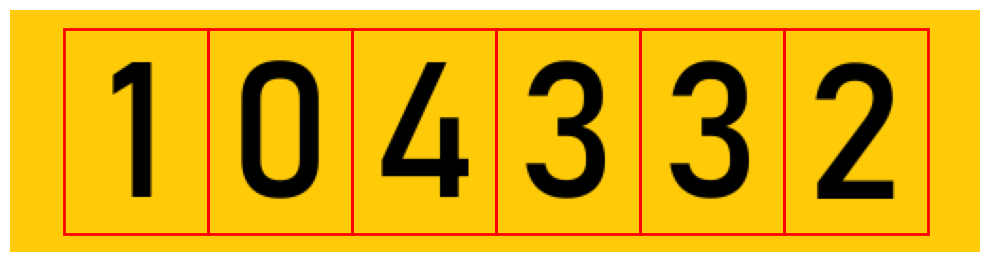

In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

seed = 42
random.seed(seed)
np.random.seed(seed)

# Plate settings
plate_width = 512
plate_height = 128
font_size = 100
num_chars = 6
fill_density = 0.9

# Generate plate number and base image
plate_number = "".join(str(random.randint(0, 9)) for _ in range(num_chars))
base_plate = Image.new("RGB", (plate_width, plate_height), (255, 203, 9))
drawer = ImageDraw.Draw(base_plate)
try:
    font = ImageFont.truetype("bahnschrift.ttf", font_size)
except IOError:
    font = ImageFont.load_default()

# Compute character positions and draw them
usable_width = plate_width * fill_density
cell_width = int(usable_width / num_chars)
margin_x = int((plate_width - cell_width * num_chars) / 2)
margin_y = 10
center_y = plate_height / 2

for i, char in enumerate(plate_number):
    left, top, right, bottom = drawer.textbbox((0, 0), char, font=font)
    char_w, char_h = right - left, bottom - top
    cell_left = margin_x + i * cell_width
    center_x = cell_left + cell_width / 2
    x = center_x - char_w / 2 - left
    y = center_y - char_h / 2 - top
    drawer.text((x, y), char, fill=(0, 0, 0), font=font)

# Define bounding boxes for each digit
digit_bboxes = [
    (margin_x + i * cell_width, margin_y, cell_width, plate_height - 2 * margin_y) for i in range(num_chars)
]

# Convert to array for plotting
plate_arr = np.array(base_plate)

# Plot original plate with red bounding boxes
fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(plate_arr)
for x, y, w, h in digit_bboxes:
    rect = patches.Rectangle((x, y), w, h, edgecolor="red", facecolor="none", linewidth=2)
    ax.add_patch(rect)
ax.axis("off")
plt.tight_layout()
plt.show()

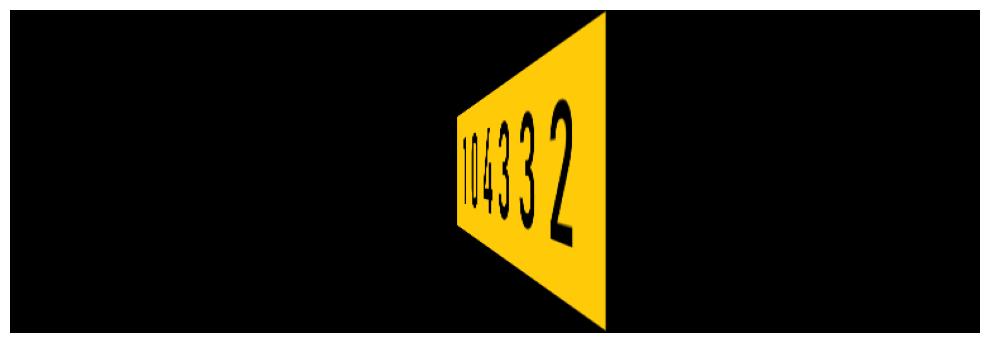

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random

seed = 42
random.seed(seed)
np.random.seed(seed)

alpha, beta = 80, 0
focal_length = plate_width

plate_pil, src_pts, plate_num, _ = create_license_plate(plate_width, plate_height, font_size)
plate_rgb = np.array(plate_pil)
warped_img, dst_pts = warp_image(plate_rgb, src_pts, alpha, beta, focal_length)

plt.figure(figsize=(10, 5))
plt.imshow(warped_img)
plt.axis("off")
plt.tight_layout()
plt.show()

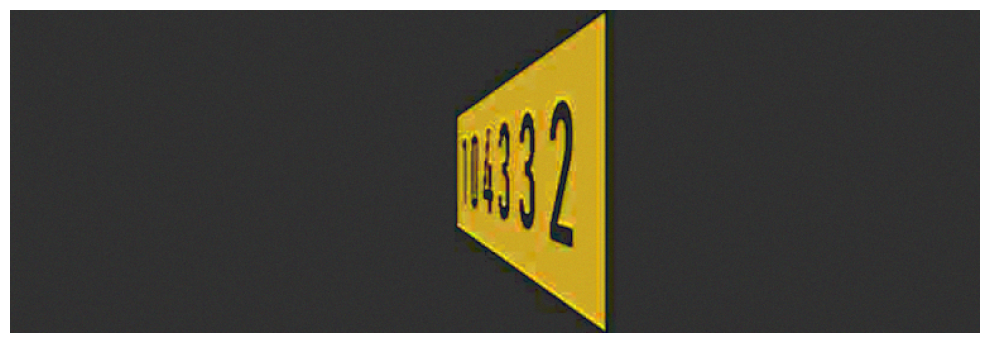

In [14]:
import numpy as np
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)
random.seed(seed)

padded_img, src_pts, plate_number, bboxes = create_license_plate(
    plate_width=plate_width, plate_height=plate_height, font_size=font_size
)
img_rgb = np.array(padded_img)

warped_rgb, dst_pts = warp_image(image=img_rgb, src_points=src_pts, alpha=alpha, beta=beta, f=focal_length)

noisy_rgb = simulate_noise(warped_rgb)

#  Plot the noisy, warped plate
plt.figure(figsize=(10, 5))
plt.imshow(noisy_rgb)
plt.axis("off")
plt.tight_layout()
plt.show()

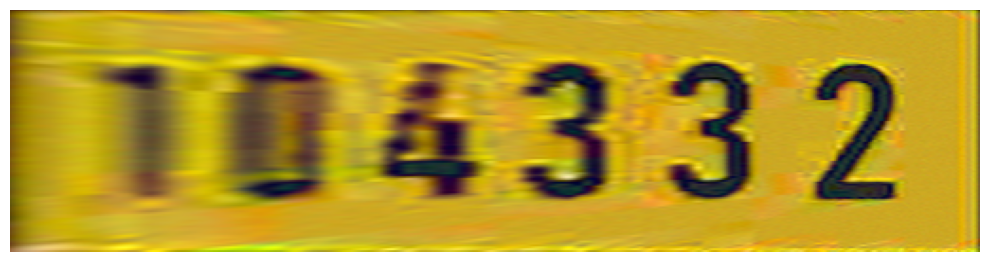

In [ ]:
dewarped_rgb = dewarp_image(noisy_rgb, src_pts, dst_pts)
crop_clean = crop_to_original_size(img_rgb, plate_width, plate_height)
crop_dist = crop_to_original_size(dewarped_rgb, plate_width, plate_height)

output_size = (256, 64)
crop_clean_ds, _ = downscale_plate(crop_clean, [], output_size)
crop_dist_ds, _ = downscale_plate(crop_dist, bboxes, output_size)

plt.figure(figsize=(10, 5))
plt.imshow(crop_dist)
plt.axis("off")
plt.tight_layout()
plt.show()

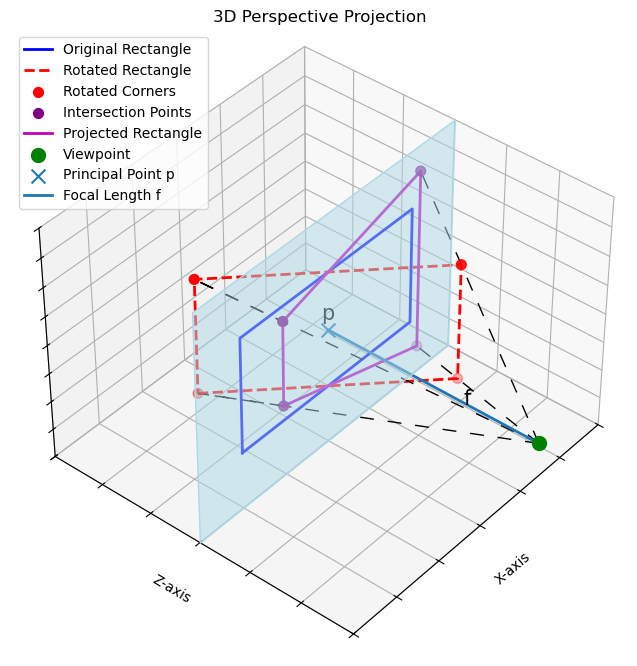

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def rotate_around_y(points, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    rotation_matrix = np.array([[cos_a, 0, sin_a], [0, 1, 0], [-sin_a, 0, cos_a]])
    return points @ rotation_matrix.T


def intersect_line_with_plane(p1, p2, plane_z=0):
    t = (plane_z - p1[2]) / (p2[2] - p1[2])
    return p1 + t * (p2 - p1)


# Original rectangle in the xy-plane (z=0)
rectangle = np.array(
    [[-1, -1, 0], [1, -1, 0], [1, 1, 0], [-1, 1, 0]]  # Bottom-left  # Bottom-right  # Top-right  # Top-left
)

# Define the plane
plane = np.array(
    [[-1.5, -2, 0], [1.5, -2, 0], [1.5, 2, 0], [-1.5, 2, 0]]  # Bottom-left  # Bottom-right  # Top-right  # Top-left
)

# Rotate the corner points around the Y-axis by 45 degrees
rotated_rectangle = rotate_around_y(rectangle, angle_deg=45)

# Define the viewpoint (camera position)
viewpoint = np.array([0, 0, -2])

# Compute intersections with the z=0 plane
intersections = np.array(
    [intersect_line_with_plane(rotated_rectangle[i], viewpoint) for i in range(len(rotated_rectangle))]
)

# define principal point and focal length
principal_point = np.array([0, 0, 0])  # camera optical center on image plane
f = np.linalg.norm(viewpoint - principal_point)  # focal length distance

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the plane with bluish tint
plane_verts = [list(zip(plane[:, 0], plane[:, 2], plane[:, 1]))]
ax.add_collection3d(Poly3DCollection(plane_verts, color="lightblue", alpha=0.5))

# Plot the original rectangle
original_rect_closed = np.vstack([rectangle, rectangle[0]])
ax.plot(
    original_rect_closed[:, 0],
    original_rect_closed[:, 2],
    original_rect_closed[:, 1],
    "b-",
    linewidth=2,
    label="Original Rectangle",
)

# Plot the rotated rectangle as dashed
rotated_rect_closed = np.vstack([rotated_rectangle, rotated_rectangle[0]])
ax.plot(
    rotated_rect_closed[:, 0],
    rotated_rect_closed[:, 2],
    rotated_rect_closed[:, 1],
    "r--",
    linewidth=2,
    label="Rotated Rectangle",
)

# scatter the rotated corners
ax.scatter(
    rotated_rectangle[:, 0],
    rotated_rectangle[:, 2],
    rotated_rectangle[:, 1],
    color="red",
    marker="o",
    s=50,
    label="Rotated Corners",
)

# Plot dashed lines from the viewpoint through rotated corners to intersection points
for i in range(len(rotated_rectangle)):
    xs = [viewpoint[0], rotated_rectangle[i, 0], intersections[i, 0]]
    ys = [viewpoint[2], rotated_rectangle[i, 2], intersections[i, 2]]
    zs = [viewpoint[1], rotated_rectangle[i, 1], intersections[i, 1]]
    ax.plot(xs, ys, zs, "k--", linewidth=1, dashes=[10, 10])

# Plot the intersection points and projected rectangle
ax.scatter(
    intersections[:, 0], intersections[:, 2], intersections[:, 1], color="purple", s=50, label="Intersection Points"
)
intersections_closed = np.vstack([intersections, intersections[0]])
ax.plot(
    intersections_closed[:, 0],
    intersections_closed[:, 2],
    intersections_closed[:, 1],
    "m-",
    linewidth=2,
    label="Projected Rectangle",
)

# Plot the viewpoint
ax.scatter(viewpoint[0], viewpoint[2], viewpoint[1], color="g", s=100, label="Viewpoint")

# plot principal point and focal length
ax.scatter(principal_point[0], principal_point[2], principal_point[1], marker="x", s=100, label="Principal Point p")
# Label 'p' above the principal point
ax.text(
    principal_point[0],
    principal_point[2],
    principal_point[1] + 0.1,
    "p",
    fontsize=15,
    horizontalalignment="center",
    verticalalignment="bottom",
)
# Draw and label focal length
ax.plot(
    [viewpoint[0], principal_point[0]],
    [viewpoint[2], principal_point[2]],
    [viewpoint[1], principal_point[1]],
    linewidth=2,
    label="Focal Length f",
)
mid = (viewpoint + principal_point) / 1.5
ax.text(mid[0], mid[2], mid[1], "f", fontsize=15, horizontalalignment="center")

# Final touches
ax.set_title("3D Perspective Projection")
ax.set_xlabel("X-axis")
ax.set_ylabel("Z-axis")
ax.set_zlabel("Y-axis")
ax.legend()
ax.view_init(elev=40, azim=-140)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-2, 2)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

C:\Users\stopc\AppData\Local\Temp\ipykernel_14872\1320128982.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', 4)


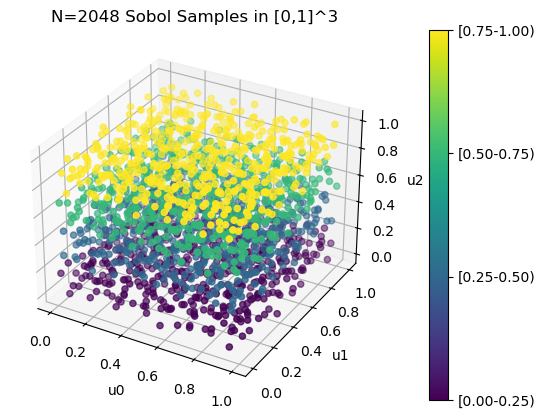

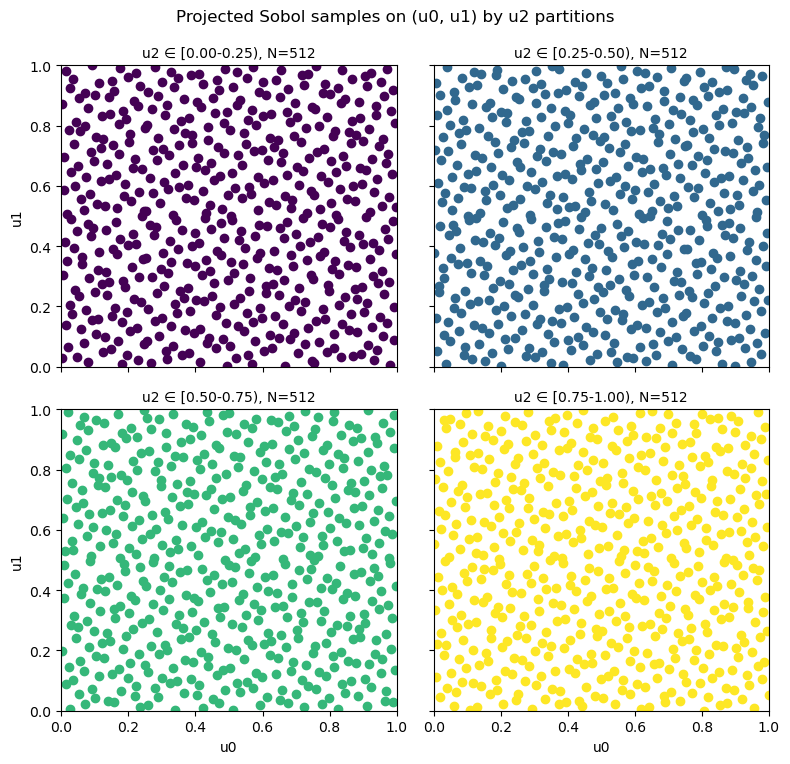

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from mpl_toolkits.mplot3d import Axes3D

# Parameters
m_power = 11  # log2 of number of points
N = 2**m_power

# Generate Sobol sequence in 3D
sobol = qmc.Sobol(d=3, scramble=True, seed=42)
u = sobol.random_base2(m=m_power)

# Extract coordinates
u0, u1, u2 = u[:, 0], u[:, 1], u[:, 2]

# Determine region (quadrant assignment) based on u2
region_id = np.minimum((u2 * 4).astype(int), 3)

# Plot Sobol samples colored by their u2 slice
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(u0, u1, u2, c=region_id)
ax.set_xlabel("u0")
ax.set_ylabel("u1")
ax.set_zlabel("u2")
ax.set_title(f"N={N} Sobol Samples in [0,1]^3")

# Add colorbar to indicate region mapping
cbar = plt.colorbar(sc, ax=ax, pad=0.1, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(["[0.00-0.25)", "[0.25-0.50)", "[0.50-0.75)", "[0.75-1.00)"])

# Viridis colors corresponding to each region (same mapping as initial 3D plot)
viridis = plt.cm.get_cmap("viridis", 4)
colors = viridis(range(4))

# Prepare 2x2 subplot with consistent colors
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
intervals = ["[0.00-0.25)", "[0.25-0.50)", "[0.50-0.75)", "[0.75-1.00)"]

for i, ax in enumerate(axes.flatten()):
    idx = region_id == i
    ax.scatter(u0[idx], u1[idx], color=colors[i])
    ax.set_title(f"u2 ∈ {intervals[i]}, N={np.sum(idx)}", fontsize=10)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if i in (2, 3):
        ax.set_xlabel("u0")
    if i in (0, 2):
        ax.set_ylabel("u1")

fig.suptitle("Projected Sobol samples on (u0, u1) by u2 partitions", y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

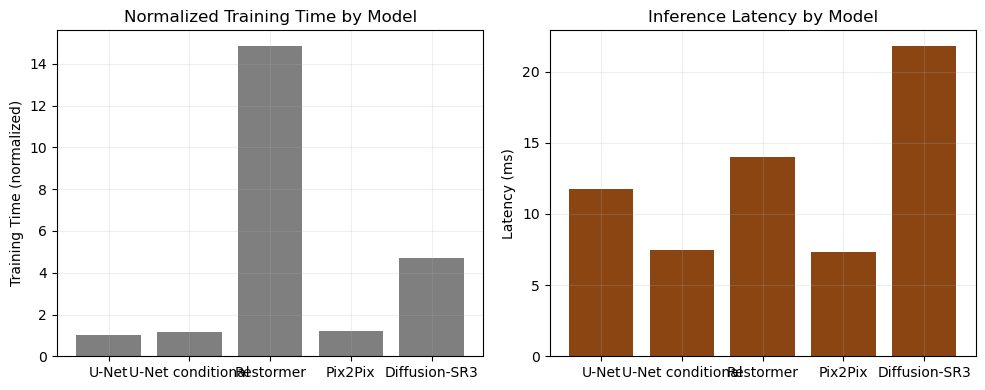

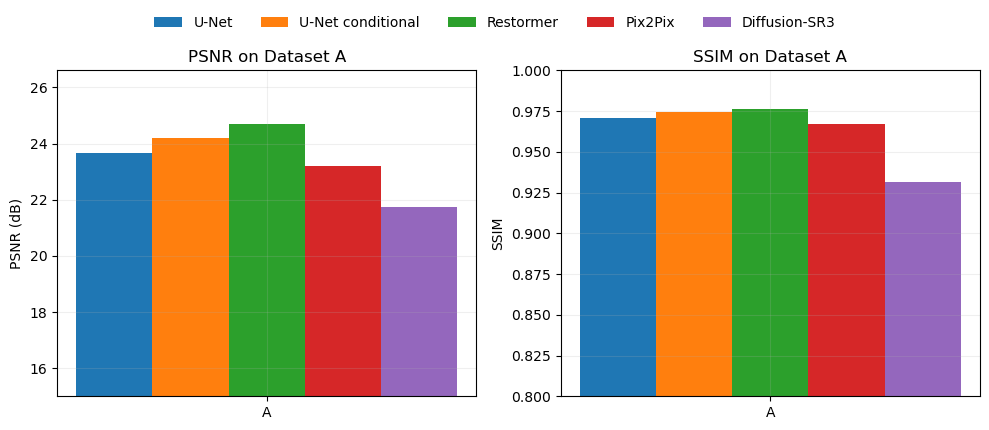

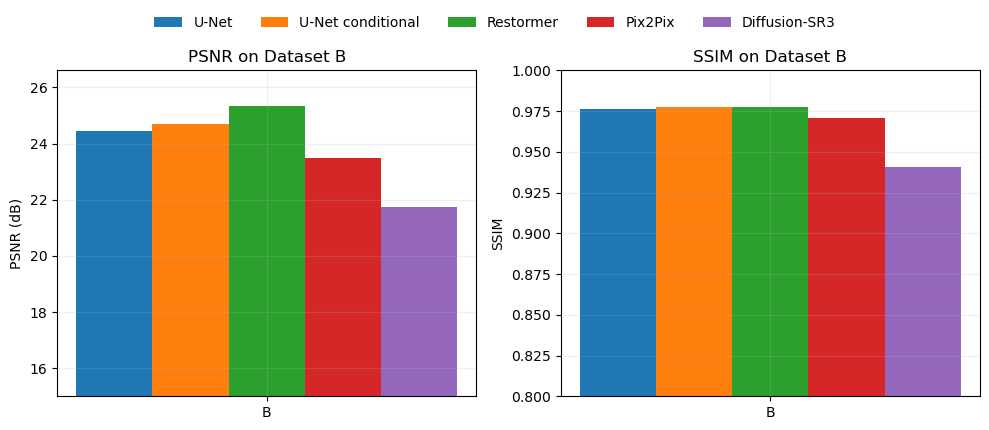

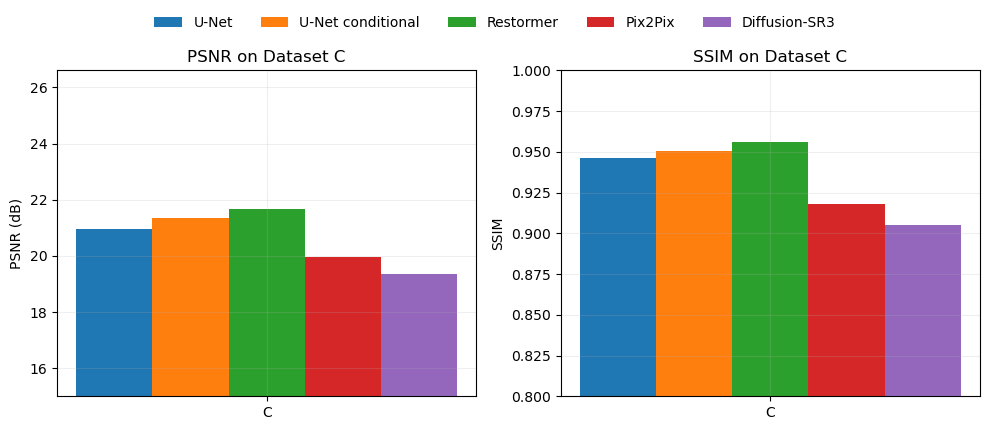

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = {
    "Model": ["U-Net", "U-Net conditional", "Restormer", "Pix2Pix", "Diffusion-SR3"],
    "PSNR_A": [23.66, 24.18, 24.71, 23.21, 21.74],
    "SSIM_A": [0.9705, 0.9743, 0.9762, 0.9672, 0.9315],
    "PSNR_B": [24.45, 24.70, 25.34, 23.48, 21.74],
    "SSIM_B": [0.9762, 0.9773, 0.9777, 0.9708, 0.9407],
    "PSNR_C": [20.96, 21.35, 21.67, 19.97, 19.34],
    "SSIM_C": [0.9464, 0.9508, 0.9563, 0.9177, 0.9052],
}
durations_min = {
    "U-Net": 11.3,
    "U-Net conditional": 13.4,
    "Restormer": 2.8 * 60,
    "Pix2Pix": 13.9,
    "Diffusion-SR3": 53.0,
}
base_time = durations_min["U-Net"]
train_time_norm = {m: durations_min[m] / base_time for m in durations_min}
latency = {
    "U-Net": 11.75,
    "U-Net conditional": 7.50,
    "Restormer": 14.01,
    "Pix2Pix": 7.34,
    "Diffusion-SR3": 21.81,
}

df_metrics = pd.DataFrame(data).set_index("Model")
models = df_metrics.index.tolist()
datasets = ["A", "B", "C"]

#  Figure 1: Training time & Latency 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Normalized Training Time
axes[0].bar(models,
            [train_time_norm[m] for m in models],
            color="tab:gray")
axes[0].set_ylabel("Training Time (normalized)")
axes[0].set_title("Normalized Training Time by Model")
axes[0].grid(alpha=0.2)

# Inference Latency
axes[1].bar(models,
            [latency[m] for m in models],
            color="saddlebrown")
axes[1].set_ylabel("Latency (ms)")
axes[1].set_title("Inference Latency by Model")
axes[1].grid(alpha=0.2)

fig.tight_layout()
plt.show()


#  Figures 2–4: PSNR & SSIM for each dataset separately
for ds in datasets:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    x = np.arange(1)        
    width = 0.15

    # PSNR on Dataset ds
    ax = axes[0]
    for i, model in enumerate(models):
        val = df_metrics.loc[model, f"PSNR_{ds}"]
        ax.bar(x + i * width - 2 * width,
               val,
               width,
               label=model,
               color=plt.get_cmap("tab10")(i))
    ax.set_xticks(x)
    ax.set_xticklabels([ds])
    ax.set_ylabel("PSNR (dB)")
    ax.set_title(f"PSNR on Dataset {ds}")
    ax.set_ylim(15, df_metrics[[f"PSNR_{d}" for d in datasets]].values.max() * 1.05)
    ax.grid(alpha=0.2)

    # SSIM on Dataset ds
    ax = axes[1]
    for i, model in enumerate(models):
        val = df_metrics.loc[model, f"SSIM_{ds}"]
        ax.bar(x + i * width - 2 * width,
               val,
               width,
               label=model,
               color=plt.get_cmap("tab10")(i))
    ax.set_xticks(x)
    ax.set_xticklabels([ds])
    ax.set_ylabel("SSIM")
    ax.set_title(f"SSIM on Dataset {ds}")
    ax.set_ylim(0.8, 1.0)
    ax.grid(alpha=0.2)

    # Single legend above both subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=len(models),
        frameon=False,
        bbox_to_anchor=(0.5, 1.08),
    )

    fig.tight_layout()
    plt.show()


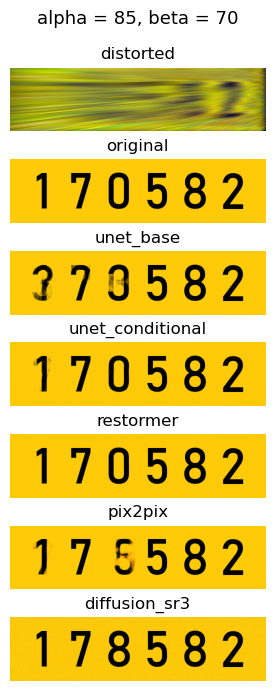

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

alpha_target = 85
beta_target = 70

model_folders = [
    "unet_base",
    "unet_conditional",
    "restormer",
    "pix2pix",
    "diffusion_sr3",
]

# Paths relative to project root
metadata_path = os.path.join("data", "full_grid", "metadata.json")
images_dir = os.path.join("data", "full_grid")
results_dir = os.path.join("results", "B")

# Find index for alpha/beta
with open(metadata_path, "r") as f:
    metadata = json.load(f)

for entry in metadata:
    if entry.get("alpha") == alpha_target and entry.get("beta") == beta_target:
        index = entry["index"]
        break

# Load original and distorted
orig_path = os.path.join(images_dir, f"original_{index}.png")
dist_path = os.path.join(images_dir, f"distorted_{index}.png")

images = [
    ("distorted", mpimg.imread(dist_path)),
    ("original", mpimg.imread(orig_path)),
]

# Load reconstructions
for model in model_folders:
    img_file = f"reconstructed_{index}.png"
    img_path = os.path.join(results_dir, model, img_file)
    if not os.path.isfile(img_path):
        raise FileNotFoundError(f"Missing {img_path}")
    images.append((model, mpimg.imread(img_path)))

# Plot
fig, axes = plt.subplots(7, 1, figsize=(3, 7))
axes = axes.flatten()

for ax, (title, img) in zip(axes, images):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")


fig.suptitle(f"alpha = {alpha_target}, beta = {beta_target}", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

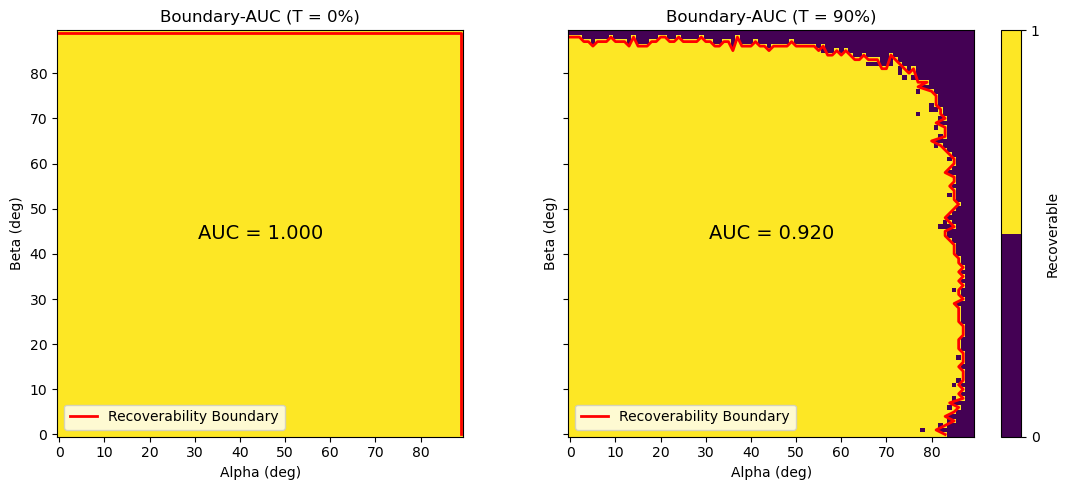

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("results/A/restormer.csv")
agg_all = df.groupby(["alpha", "beta"])["ocr_plate"].mean().reset_index()

# Prepare angle grids
alpha_vals = np.sort(agg_all["alpha"].unique())
beta_vals = np.sort(agg_all["beta"].unique())
A, B = np.meshgrid(alpha_vals, beta_vals)
max_angle = alpha_vals.max()

# Thresholds for subplots
thresholds = [0.0, 0.9]

# Create 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(11.5, 5), sharex=True, sharey=True)

for ax, T in zip(axs, thresholds):
    # Determine recoverability grid
    agg = agg_all.copy()
    agg["rec"] = (agg["ocr_plate"] >= T).astype(int)
    grid = (
        agg.pivot(index="beta", columns="alpha", values="rec")
        .reindex(index=beta_vals, columns=alpha_vals, fill_value=0)
        .values
    )

    # Compute axis-wise maxima
    beta_max_alpha = [
        beta_vals[grid[:, j] == 1].max() if (grid[:, j] == 1).any() else 0 for j in range(len(alpha_vals))
    ]
    alpha_max_beta = [
        alpha_vals[grid[i, :] == 1].max() if (grid[i, :] == 1).any() else 0 for i in range(len(beta_vals))
    ]

    # Build stitched boundary points
    boundary = []
    for j, a in enumerate(alpha_vals):
        b_ma = beta_max_alpha[j]
        if b_ma >= a:
            boundary.append((a, b_ma))
    for b, a_ma in zip(beta_vals[::-1], alpha_max_beta[::-1]):
        if a_ma >= b:
            boundary.append((a_ma, b))
    env_alpha, env_beta = zip(*boundary)

    # Compute symmetric AUC
    auc_bxa = np.trapz(beta_max_alpha, x=alpha_vals)
    auc_axb = np.trapz(alpha_max_beta, x=beta_vals)
    auc = 0.5 * (auc_bxa + auc_axb) / (max_angle * max_angle)

    # Plot recoverability heatmap
    cmap = plt.get_cmap("viridis", 2)
    pcm = ax.pcolormesh(A, B, grid, cmap=cmap, shading="auto", vmin=0, vmax=1)
    ax.plot(env_alpha, env_beta, color="red", linewidth=2, label="Recoverability Boundary")
    ax.legend(loc="lower left")

    mid = max_angle / 2
    ax.text(mid, mid, f"AUC = {auc:.3f}", ha="center", va="center", fontsize=14, color="black")

    ax.set_title(f"Boundary-AUC (T = {T*100:.0f}%)")
    ax.set_xlabel("Alpha (deg)")
    ax.set_ylabel("Beta (deg)")
    ax.set_aspect("equal")

# Add colorbar only to the right subplot
cbar = fig.colorbar(pcm, ax=axs[1], ticks=[0, 1], label="Recoverable")


plt.tight_layout()
plt.show()

T = 0.0 → number of holes = 0
  total sum of d_h = 0.000
  RMS hole-distance F = 0.000

T = 0.9 → number of holes = 33
  hole at (α=78, β=1) → d_h = 3.000
  hole at (α=82, β=2) → d_h = 1.000
  hole at (α=84, β=3) → d_h = 1.000
  hole at (α=84, β=6) → d_h = 1.000
  hole at (α=85, β=8) → d_h = 1.414
  hole at (α=85, β=11) → d_h = 1.000
  hole at (α=86, β=12) → d_h = 1.000
  hole at (α=86, β=17) → d_h = 1.000
  hole at (α=85, β=32) → d_h = 1.000
  hole at (α=82, β=46) → d_h = 1.414
  hole at (α=83, β=46) → d_h = 1.000
  hole at (α=84, β=46) → d_h = 1.000
  hole at (α=83, β=47) → d_h = 1.000
  hole at (α=84, β=53) → d_h = 1.000
  hole at (α=84, β=61) → d_h = 1.000
  hole at (α=81, β=64) → d_h = 1.000
  hole at (α=82, β=66) → d_h = 1.000
  hole at (α=81, β=68) → d_h = 1.000
  hole at (α=82, β=70) → d_h = 1.000
  hole at (α=77, β=71) → d_h = 4.472
  hole at (α=80, β=72) → d_h = 1.414
  hole at (α=81, β=72) → d_h = 1.000
  hole at (α=80, β=73) → d_h = 1.000
  hole at (α=77, β=76) → d_h = 1.00

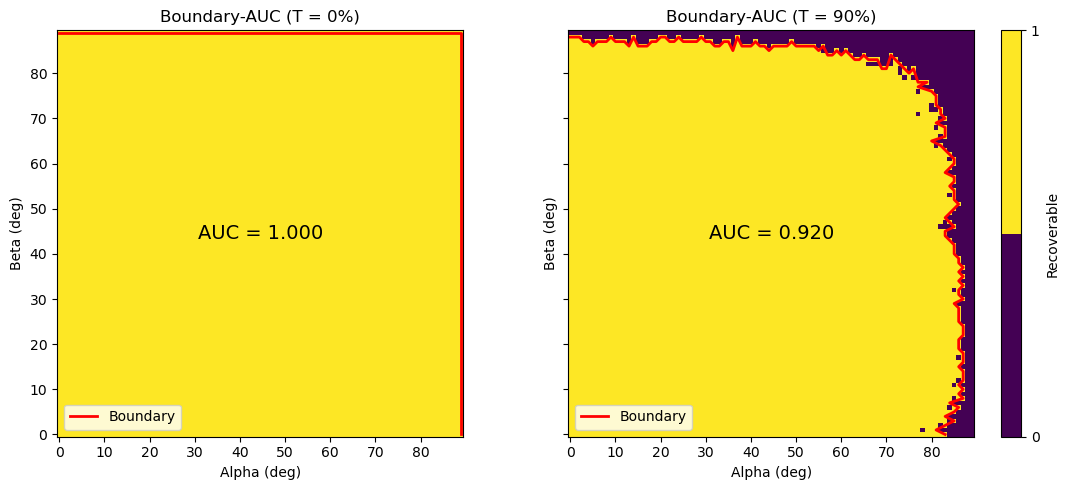

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("results/A/restormer.csv")
agg_all = df.groupby(["alpha", "beta"])["ocr_plate"].mean().reset_index()

# Prepare angle grids
alpha_vals = np.sort(agg_all["alpha"].unique())  # 0…89
beta_vals = np.sort(agg_all["beta"].unique())  # 0…89
A, B = np.meshgrid(alpha_vals, beta_vals)  # shape (90,90)

max_angle = alpha_vals.max()  # 89
thresholds = [0.0, 0.9]

fig, axs = plt.subplots(1, 2, figsize=(11.5, 5), sharex=True, sharey=True)

for ax, T in zip(axs, thresholds):

    #  Binary recoverability grid
    tmp = agg_all.copy()
    tmp["rec"] = (tmp["ocr_plate"] >= T).astype(int)
    grid = (
        tmp.pivot(index="beta", columns="alpha", values="rec")
        .reindex(index=beta_vals, columns=alpha_vals, fill_value=0)
        .values
    )

    #  Axis-wise maxima (βmax(α), αmax(β))
    beta_max_alpha = [beta_vals[grid[:, j] == 1].max() if grid[:, j].any() else 0 for j in range(len(alpha_vals))]
    alpha_max_beta = [alpha_vals[grid[i, :] == 1].max() if grid[i, :].any() else 0 for i in range(len(beta_vals))]

    #  Stitched recoverability boundary
    boundary = []
    for a, b in zip(alpha_vals, beta_max_alpha):
        if b >= a:
            boundary.append((a, b))
    for b, a in zip(beta_vals[::-1], alpha_max_beta[::-1]):
        if a >= b:
            boundary.append((a, b))
    env_alpha, env_beta = zip(*boundary)

    #  Inside mask via analytical inequalities
    beta_max_arr = np.array(beta_max_alpha)
    alpha_max_arr = np.array(alpha_max_beta)

    inside_vert = B <= beta_max_arr[np.newaxis, :]
    inside_horiz = A <= alpha_max_arr[:, np.newaxis]
    inside = inside_vert & inside_horiz

    #  Holes: failures that lie inside the boundary region
    holes_mask = inside & (grid == 0)
    hole_idxs = np.argwhere(holes_mask)
    num_holes = int(hole_idxs.shape[0])
    print(f"T = {T:.1f} → number of holes = {num_holes}")

    #  Distances from holes to the boundary
    b_arr = np.array(boundary)
    dists = []
    for i, j in hole_idxs:
        alpha_h = alpha_vals[j]
        beta_h = beta_vals[i]
        pt = np.array([alpha_h, beta_h])
        d_h = np.linalg.norm(b_arr - pt, axis=1).min()
        dists.append(d_h)
        print(f"  hole at (α={alpha_h}, β={beta_h}) → d_h = {d_h:.3f}")

    total_d = sum(dists)
    print(f"  total sum of d_h = {total_d:.3f}")

    #  Region area E (symmetric) and RMS hole-distance F
    E = 0.5 * (sum(beta_max_alpha) + sum(alpha_max_beta))
    F = np.sqrt(sum(d * d for d in dists) / E) if dists else 0.0
    print(f"  RMS hole-distance F = {F:.3f}\n")

    #  Boundary-AUC
    auc_bxa = np.trapz(beta_max_alpha, x=alpha_vals)
    auc_axb = np.trapz(alpha_max_beta, x=beta_vals)
    auc = 0.5 * (auc_bxa + auc_axb) / (max_angle * max_angle)

    #  Plot heatmap and boundary
    pcm = ax.pcolormesh(A, B, grid, cmap=plt.get_cmap("viridis", 2), shading="auto", vmin=0, vmax=1)
    ax.plot(env_alpha, env_beta, color="red", lw=2, label="Boundary")
    ax.legend(loc="lower left")

    mid = max_angle / 2
    ax.text(mid, mid, f"AUC = {auc:.3f}", ha="center", va="center", fontsize=14, color="black")

    ax.set_title(f"Boundary-AUC (T = {T*100:.0f}%)")
    ax.set_xlabel("Alpha (deg)")
    ax.set_ylabel("Beta (deg)")
    ax.set_aspect("equal")

# Add colorbar on the right subplot
fig.colorbar(pcm, ax=axs[1], ticks=[0, 1], label="Recoverable")
plt.tight_layout()
plt.show()